### Этап 1. Получение данных

Изучим данные, предоставленные сервисом для проекта.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15,8)
pd.options.mode.chained_assignment = None

Прочитаем файл data.csv и сохраним его в переменной df.

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [3]:
df.sample(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
13079,9,4500000.0,44.0,2017-09-10T00:00:00,1,NaN,22.0,34.0,9,NaN,...,10.0,2.0,Санкт-Петербург,13275.0,12071.0,0.0,NaN,0.0,NaN,59.0
17426,0,9200000.0,121.4,2017-09-29T00:00:00,3,3.40,3.0,75.2,3,NaN,...,21.2,NaN,Санкт-Петербург,24140.0,2689.0,0.0,NaN,3.0,202.0,102.0
9992,20,5950000.0,55.0,2017-04-08T00:00:00,2,2.55,5.0,32.0,3,False,...,14.0,1.0,Санкт-Петербург,10782.0,10955.0,0.0,NaN,0.0,NaN,478.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Рассмотрим полученную информацию подробнее.

В представленных данных 18 количественных, 1 качественных и 3 булева параметра: всего 22 колоноки с 23699 записями.

Подробно разберём, какие в df столбцы и какую информацию они содержат:

    airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
    balcony — число балконов
    ceiling_height — высота потолков (м)
    cityCenters_nearest — расстояние до центра города (м)
    days_exposition — сколько дней было размещено объявление (от публикации до снятия)
    first_day_exposition — дата публикации
    floor — этаж
    floors_total — всего этажей в доме
    is_apartment — апартаменты (булев тип)
    kitchen_area — площадь кухни в квадратных метрах (м²)
    last_price — цена на момент снятия с публикации
    living_area — жилая площадь в квадратных метрах(м²)
    locality_name — название населённого пункта
    open_plan — свободная планировка (булев тип)
    parks_around3000 — число парков в радиусе 3 км
    parks_nearest — расстояние до ближайшего парка (м)
    ponds_around3000 — число водоёмов в радиусе 3 км
    ponds_nearest — расстояние до ближайшего водоёма (м)
    rooms — число комнат
    studio — квартира-студия (булев тип)
    total_area — площадь квартиры в квадратных метрах (м²)
    total_images — число фотографий квартиры в объявлении

### Вывод

Каждая строка таблицы - архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости.

Данные имеют разные типы: для дальнейшей работы с ними необходимо преобразовать некоторые из них. Вещественный тип данных необходимо заменить на целочисленный тип. Кроме того, тип столбца "is_apartment" необходимо заменить на bool.

Кроме того, а датасете есть пропуски по некоторым столбцам.

### Этап 2. Предобработка данных

Как указано выше, для последующего анализа, необходимо поработать над пропусками:

    1) Например, не указано количество балконов в объекте. Если не указано, возможно, его и нет (ставим 0). 
    2) Если не указано название неселенного пункта - поставим 'Unknow'.
    3) По пропуску признака "Аппартаменты" поставим False (если не проставлен признак, значит, объект не является аппартаментами).
    4) Этажность пропущена для тех объектов, что находятся на последнем этаже.
    5) Пропуски всех показателей расстояния (а также показателя высоты потолков) заменяем средним значением в зависимости от локали
    6) Заменим пропуски в значениях жилой площади и площади кухни через отношение к общей площади объекта (группировка по локали)
    7) Количество дней публикации посчитаем как кол-во дней, прошедших с даты публикации до текущей (системной) даты

Проанализируем пропуски, заменим типы данных, а также проверим данные на наличие дубликатов.

Вернем все количественными параметрам абсолютное значение, чтобы избежать неточности в анализе данных.

Как и указано ранее, в данных есть пропуски по двум параметрам. Чтобы наглядно отобразить, сколько же данных из нашего датасета пропущено, построим тепловую карту и подкрасим пропуски.

Text(0.5, 1, 'Анализ пропусков в данных')

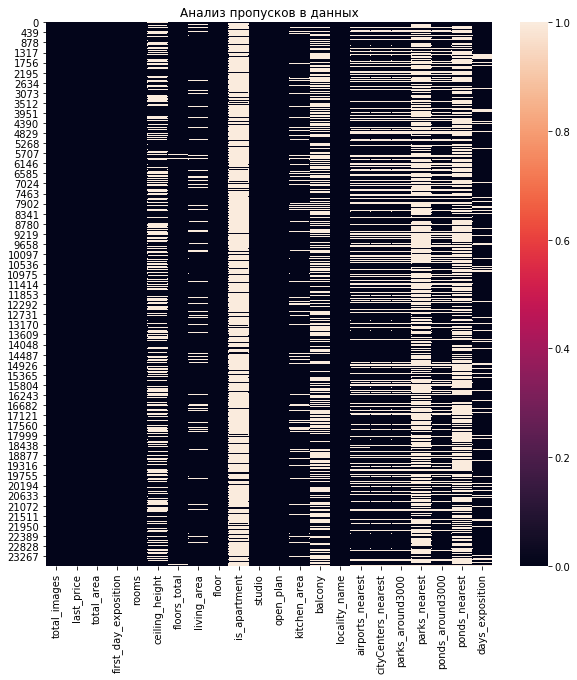

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(df.isnull()).set_title('Анализ пропусков в данных')

На рисунке видно, что там, где есть пропуски по трудовому стажу, нет информации и о доходе клиента. То есть пропуски по двум метрикам идут синхронно.

Посмотрим, по каким категориям заемщиков больше всего пропусков в данных. Выведем отношение незаполненных сведений о доходе и трудовом стаже ко всем заемщикам в этой группе.

In [6]:
# 1
df['balcony']=df['balcony'].fillna(0) 

# 2
df['locality_name']=df['locality_name'].fillna('Unknow')

# 3
df['is_apartment']=df['is_apartment'].fillna('False') 

# 4
df['floors_total']=df['floors_total'].fillna(df["floor"])

# 5
def fillna_median(column):
    df.loc[df[column].isnull(), column] = df.groupby('locality_name')[column].transform('mean')
    df[column] = df[column].fillna(df[column].median())

fillna_median('airports_nearest')
fillna_median('cityCenters_nearest')
fillna_median('parks_around3000')
fillna_median('parks_nearest')
fillna_median('ponds_around3000')
fillna_median('ponds_nearest')
fillna_median('ceiling_height')

# 6
df['liv_rate'] = round(df['living_area'] * 100 / df['total_area'], 2)
df['kit_rate'] = round(df['kitchen_area'] * 100 / df['total_area'], 2)

fillna_median('liv_rate')
fillna_median('kit_rate')

df['living_area'] = df['living_area'].fillna(df["liv_rate"] * df["total_area"])
df['kitchen_area'] = df['kitchen_area'].fillna(df["kit_rate"] * df["total_area"])

# 7
fillna_median('days_exposition')

Далее изменим тип данных на нужный: все количественные переменные сделаем целочисленными, признак апартаментов сделаем булевым значением, а дату публикации - датой.

In [7]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
for col in numeric_cols:
    df[col] = df[col].astype('int64')
   
df['is_apartment'] = df['is_apartment'].astype('bool')
df['first_day_exposition'] = df['first_day_exposition'].astype('datetime64[ns]')

Теперь в данных нет пропусков, и все типы данных таблицы корректны. Но этого не достаточно, чтобы ответить на ключевой вопрос исследования.

### Этап 3. Добавление новых столбцов

Для определения рыночной стоимости объекта необходимо знать цену квадратного метра (как отношение цены к общей площади объекта).

Text(0.5, 1.0, 'Разброс цены кв. метра')

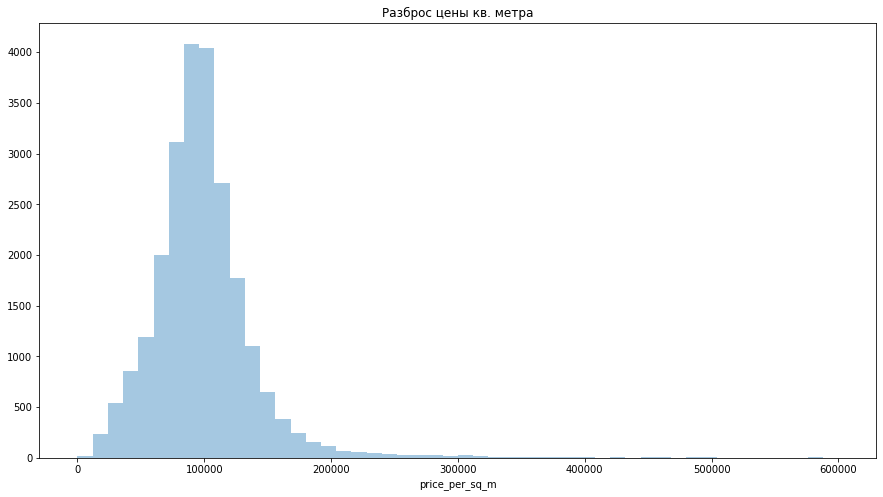

In [8]:
df['price_per_sq_m'] = round(df['last_price'] / df['total_area'], 2)

sns.distplot(df['price_per_sq_m'], 
             kde = False,
             hist_kws={"range": [0,600000]}).set_title('Разброс цены кв. метра')

Из даты публикации посмотрим день, месяц, год.

In [9]:
df['day'] = df['first_day_exposition'].dt.day
df['day_of_week'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year

Проведем категоризацию по этажности объекта (первый, последний или другой). Для это используем функцию floor_category.

In [10]:
def floor_category(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

df['floor_category'] = df.apply(floor_category, axis=1)  

Text(0.5, 1.0, 'Соотношение цены за кв.м объекта и его этажности')

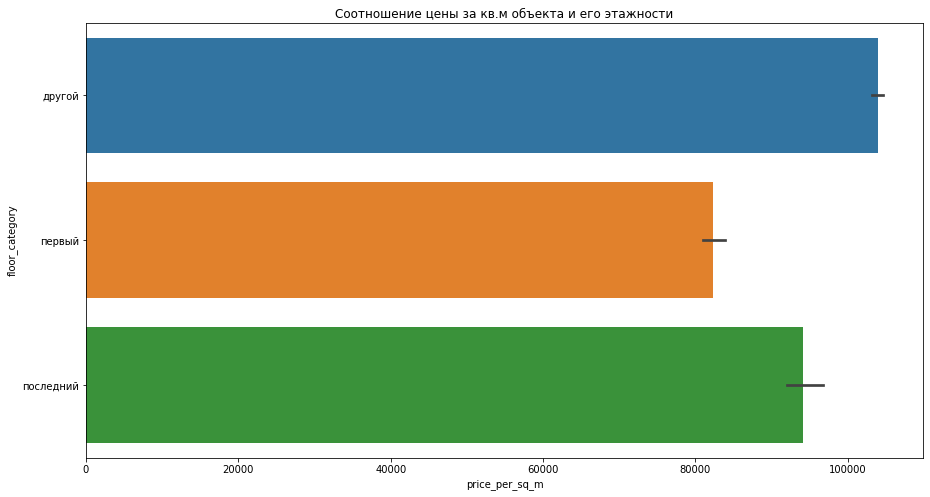

In [11]:
sns.barplot(x = "price_per_sq_m", 
            y = "floor_category", 
            data = df).set_title('Соотношение цены за кв.м объекта и его этажности')

Посмотрим, как соотносятся площадь жилой и общей площади (liv_rate), а также соотношение площади кухни к общей (kit_rate).

### Этап 4. Проведение исследовательского анализа данных

Посмотрим на распределение дней публикации, числа комнат, высоты потолков, общей и жилой площади, а также цены объектов.

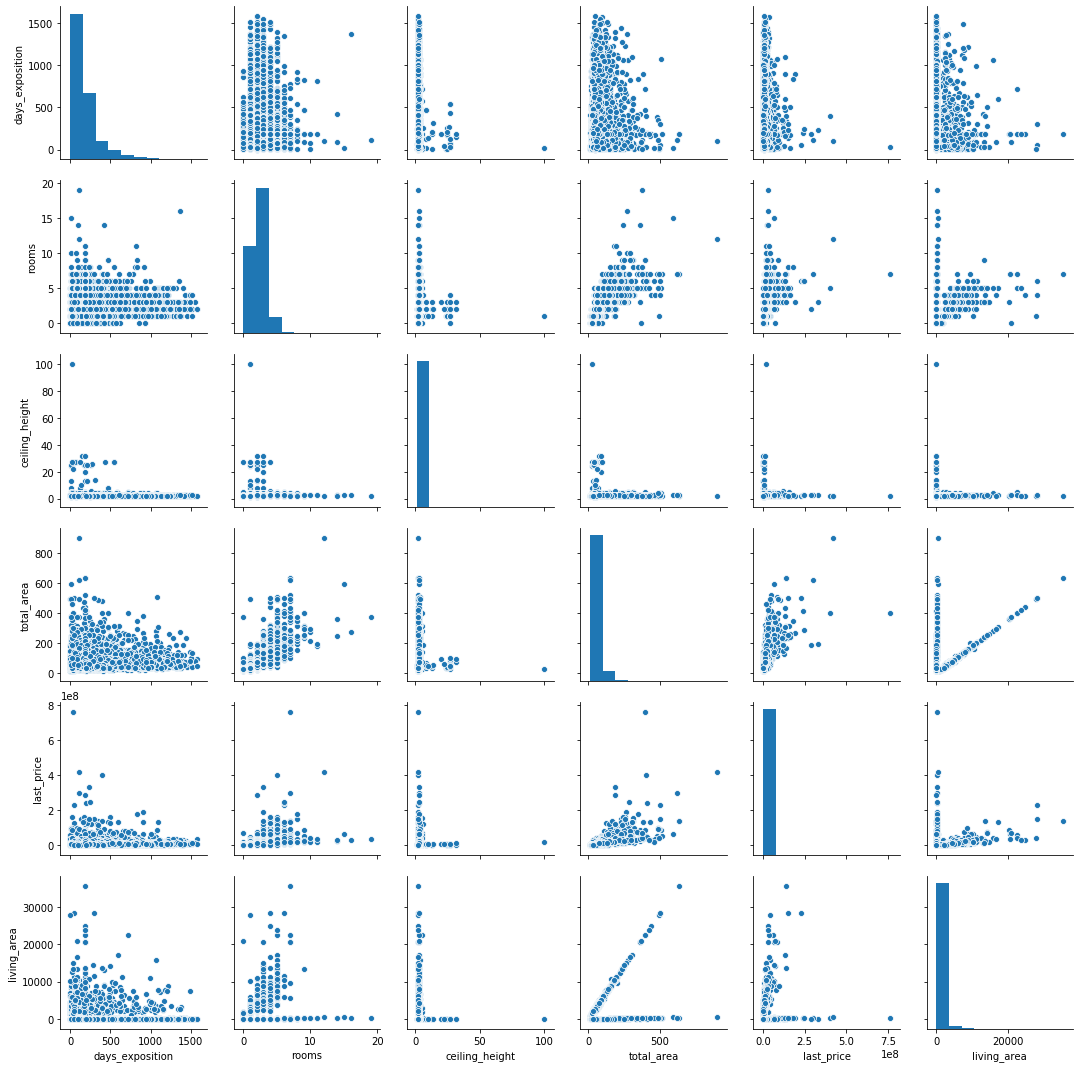

In [12]:
list = ['days_exposition', 'rooms', 'ceiling_height', 'total_area', 'last_price', 'living_area']
g = sns.pairplot(df[list])

А еще интересно посмотреть на персентели: видно, что 95% всех данных по дням публикации не превышают 604 дня, и только 5% всех объектов имеют больше 4 комнат.

In [13]:
df[list].describe(percentiles=[0.80, 0.90, 0.95])

,days_exposition,rooms,ceiling_height,total_area,last_price,living_area
count,23699.000000,23699.000000,23699.000000,23699.000000,2.369900e+04,23699.000000
mean,180.746740,2.070636,2.150639,60.120511,6.541549e+06,319.636272
std,204.955705,1.078405,1.055075,35.665822,1.088701e+07,1206.847968
min,1.000000,0.000000,1.000000,12.000000,1.219000e+04,2.000000
50%,120.000000,2.000000,2.000000,52.000000,4.650000e+06,31.000000
80%,255.000000,3.000000,2.000000,75.000000,7.585000e+06,51.000000
90%,426.000000,3.000000,3.000000,93.000000,1.091423e+07,92.000000
95%,604.000000,4.000000,3.000000,116.000000,1.530000e+07,2623.000000
max,1580.000000,19.000000,100.000000,900.000000,7.630000e+08,35703.000000


Для того, чтобы понимать закономерность в днях публикации, надо построить диаграмму размаха (а также увидеть медиану и среднее).

(0, 1580)

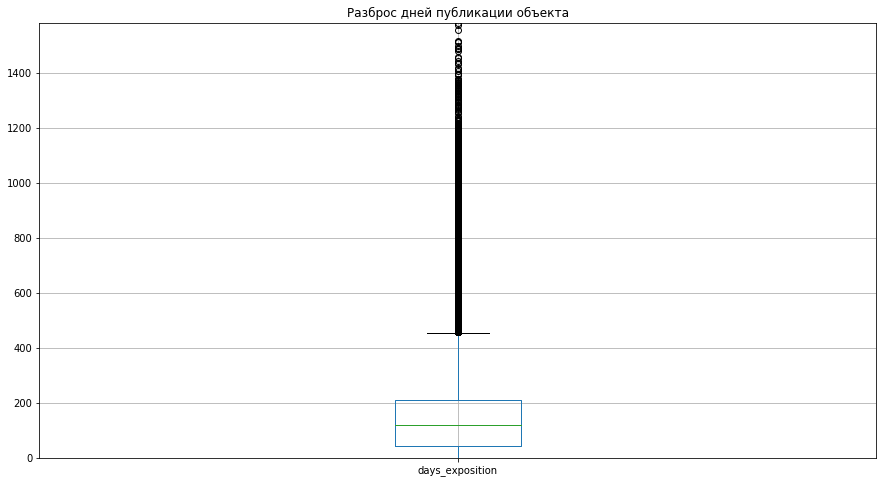

In [14]:
df.boxplot('days_exposition').set_title('Разброс дней публикации объекта')
plt.ylim(0, 1580)

In [15]:
df['days_exposition'].describe()

count    23699.000000
mean       180.746740
std        204.955705
min          1.000000
25%         45.000000
50%        120.000000
75%        209.000000
max       1580.000000
Name: days_exposition, dtype: float64

Большинство данных лежит на уровне до 200 дней (чуть больше полугода), очень много выбросов, так что точки выглядят жирной линей. Нижний «ус» упирается в 1, минимальное значение.

Верхний заканчивается около 450 дней. Большое стандартное отклонение (204), это значит, что в наборе данных серьёзные аномалии или выбросы. Если время продажи в диапазоне до 180 дней (6 месяцев), то можно считать это быстрой продажей.

Убираем редкие и выбивающиеся значения: продажа длительностью более 604 дней уже редки, более 1200 дней уже почти нет. Поэтому примем верхную границу - 604, остальных распределений не так много (2,5%), поэтому не потеряем много данных.

Далее будем работать с данными, удовлетворяющими условиям (убираем аномалии):

In [16]:
df = df.query("days_exposition <= 604 & \
               1 <= rooms <= 4 & \
               2 <= ceiling_height <= 3 & \
               20 <= total_area <= 116 & \
               kitchen_area >= 5 & \
               living_area >= 5")
print('Убрали', round((23699 - df.shape[0]) * 100 / 23699 ,2), '% датасета.')

Убрали 11.4 % датасета.


Есть подозрительный выброс в диапазоне от 180 до 185 дней:

Text(0.5, 1.0, 'Выброс в днях публикации')

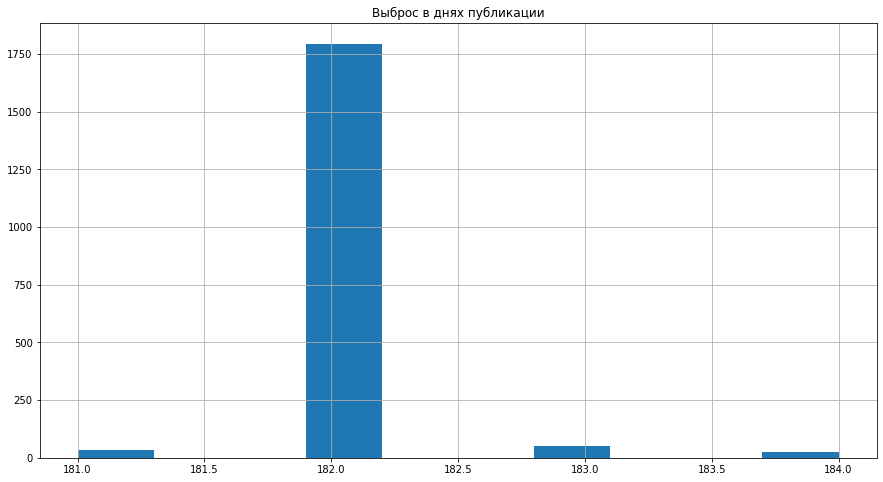

In [17]:
df.query('days_exposition < 185 and days_exposition > 180').hist('days_exposition')
plt.title('Выброс в днях публикации')

На графике виден анамальный выброс (182 дня) - это нужно зафиксировать!

Чтобы определить, какие факторы больше всего влияют на стоимость квартиры, построим матрицу корреляции

In [18]:
def matrix_corr(data, title):
    mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(data.corr(),  
                mask = mask, 
                vmax=1, 
                center=0,
                square=True, 
                linewidths=.5, 
                cbar_kws={"shrink": .5}).set_title(title)

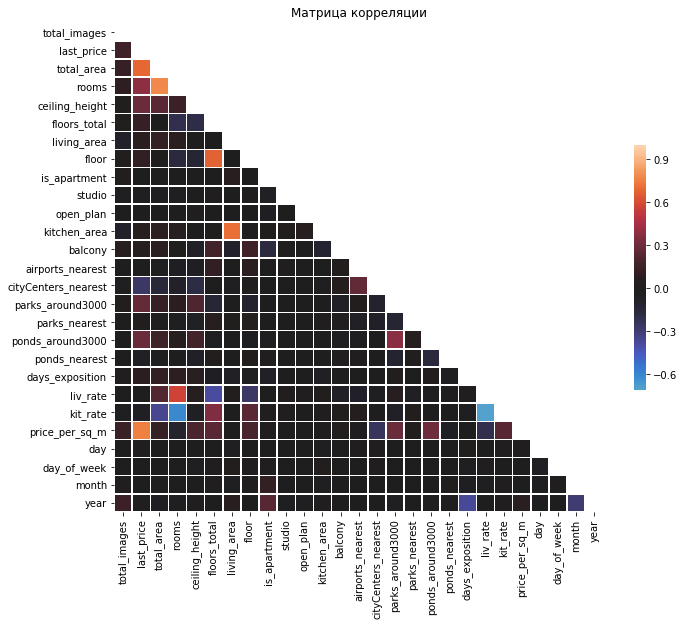

In [19]:
matrix_corr(df, 'Матрица корреляции')

Цена зависит от общей площади, а также от цены квадратного метра объекта. А вот от удаленности от центра зависимость не просматривается. Так же как и нет разницы, в какой день недели, месяц или год было опубликовано объявление о продаже объекта.

Если смотреть на разброс цен в зависимости от этажности объекта, то можно заметить более высокую цену на последний этаж относительно первого.

Text(0.5, 1.0, 'Соотношение цены объекта к его этажности')

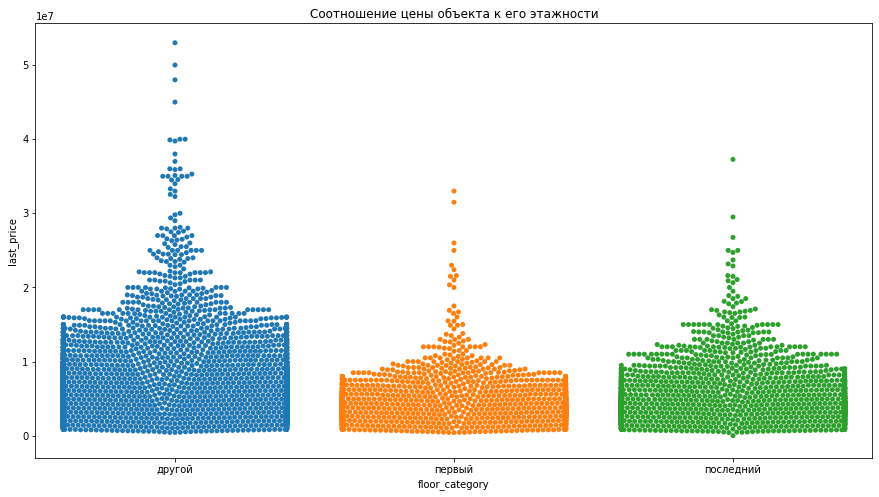

In [20]:
sns.swarmplot(x = "floor_category", y = "last_price", data = df).set_title('Соотношение цены объекта к его этажности')

Интересно посмотреть топ-10 населенных пунктов с наибольшим числом объявленей.

Text(0.5, 1.0, 'TOP-10 населенных пунктов с наибольшим числом объявленей')

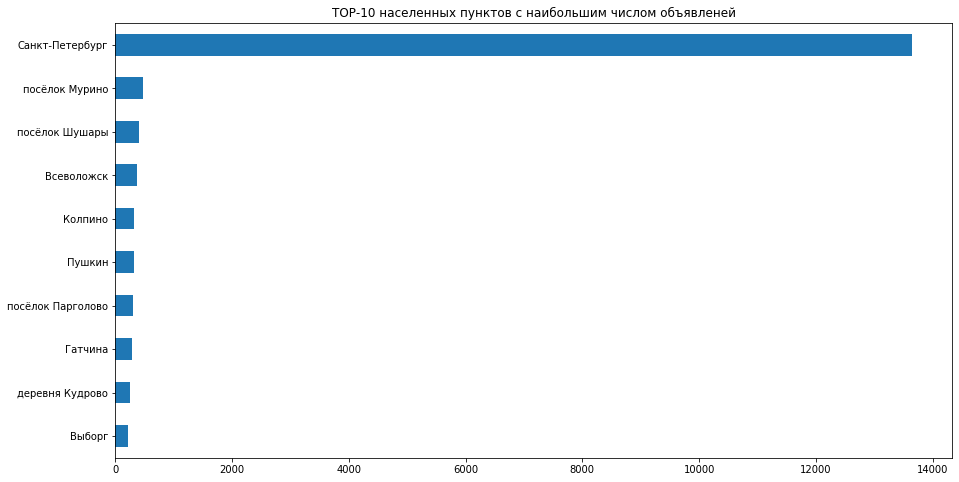

In [21]:
data_top10 = df['locality_name'].value_counts().sort_values(ascending=True).tail(10)
data_top10.plot.barh()
plt.title('TOP-10 населенных пунктов с наибольшим числом объявленей')

Средная цена квадратного метра в этих населенных пунктах:

Text(0.5, 1.0, 'Средная цена квадратного метра в TOP-10 населенных пунктов')

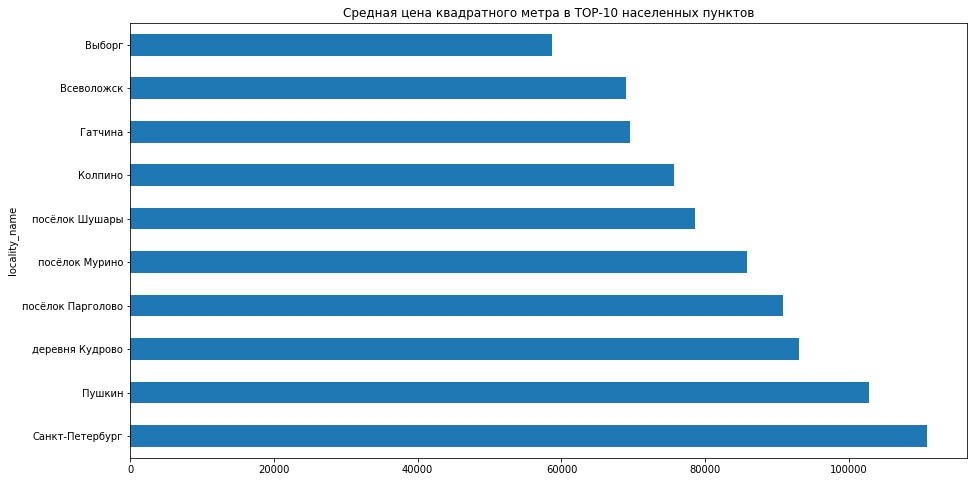

In [22]:
(df.query('locality_name in @data_top10.index')
   .groupby('locality_name')['price_per_sq_m']
   .mean()
   .sort_values(ascending=False)
   .plot.barh())
plt.title('Средная цена квадратного метра в TOP-10 населенных пунктов')

Найдем населенные пукты с самой низкой и высокой стоимостью объекта.

In [23]:
# Населенные пункты с самой высокой и низкой стоимостью жилья:
max_price = df.groupby('locality_name')['price_per_sq_m'].max().sort_values(ascending=False).head(1)
min_price = df.groupby('locality_name')['price_per_sq_m'].min().sort_values(ascending=False).head(1)

print('Самая высокая стоимость жилья в населенном пункте:', max_price.idxmax(axis=0))
print('Самая низкая стоимость жилья в населенном пункте:', min_price.idxmin(axis=0))

Самая высокая стоимость жилья в населенном пункте: Санкт-Петербург
Самая низкая стоимость жилья в населенном пункте: посёлок Лисий Нос


Посмотрим, как обстоят дела с объектами в Санкт-Петербурге.

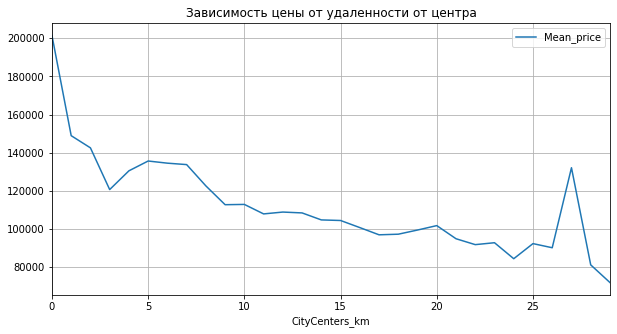

In [24]:
# Квартиры в Санкт-Петерберге:
SPB_locality = df.query('locality_name == "Санкт-Петербург"')

# Расстояние до центра к километрах:
SPB_locality['CityCenters_km'] = round(SPB_locality['cityCenters_nearest'] / 1000, 0) 

# Средняя цена для каждого километра:
pivot_price = SPB_locality.pivot_table(index = 'CityCenters_km', values = 'price_per_sq_m')
pivot_price.columns = ['Mean_price']

# Зависимость цены от удаленности от центра (центр - до 7 км)
pivot_price.plot(title='Зависимость цены от удаленности от центра', grid=True, figsize=(10, 5))

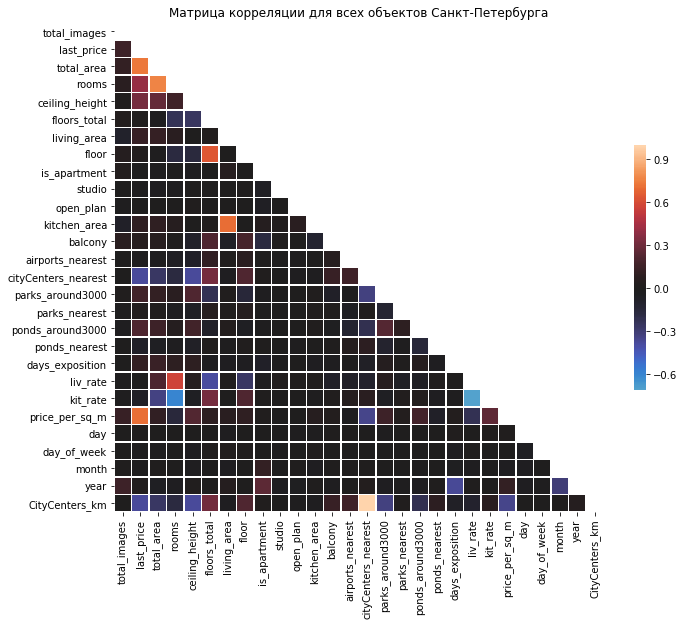

In [25]:
# Сегмент квартир в Санкт-Петербурге:
matrix_corr(SPB_locality, 'Матрица корреляции для всех объектов Санкт-Петербурга')

Посмотрим на "портрет" объектов в центре города (до 7 км).

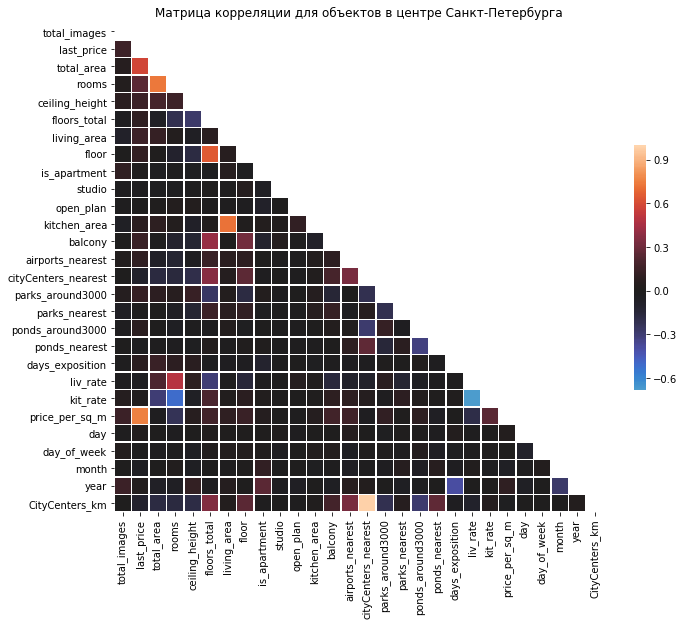

In [26]:
# Сегмент квартир в центре:
center_locality = SPB_locality.query('CityCenters_km <= 7')
matrix_corr(center_locality, 'Матрица корреляции для объектов в центре Санкт-Петербурга')

### Этап 5. Общий вывод

Самая популярный по прощади объект - от 30 до 50 кв.м., по цене продажи - от 300 до 500 тысяч, по кол-ву комнат - от 1 до 3, высоте потолка - от 2,6 до 2,9.

Обычно продажа объекта занимает в среднем до полугода, продажа считается  быстрой, если занимает меньше 180 дней.

При этом в данных наблюдается аномальный выброс в значении 182 дня, это необходимо зафиксировать для последующей подготовки аналогичных данных для анализа.

Как и ожидалось, больше всего значение цены продажи зависит от общей площади объекта и от числа комнат.

Самая низкая цена - для первого этажа, самая высокая - для последнего.

Цена практически не имеет зависимости от дня и месяца продажи, но с течением времени (лет) цена на объекты немного упала.

Самые дорогие квартиры в Санкт-Петербурге, самые дешевые - в почелке Лисий Нос.

После анализа квартир в Санкт-Петербурге выяснилось, что квартира удаленностью менее 7 км, находится в центре города.

В центре  города, так же как и в остальной части цена не зависит от даты выставления объявления, но зависит от числа комнат и этажности (при этом в центре города этажность квартиры больше влияет на цену объекта).